In [18]:
import pandas as pd
import lightgbm as lgb
from datetime import datetime
import matplotlib.pyplot as plt
import json
import numpy as np

import warnings
warnings.filterwarnings('ignore')

fase = '05_lightgbm (un intento)'

In [19]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [20]:
folder = gen_config['folder']

path_pred_test = gen_config['path_pred_test']
path_pred_futuro = gen_config['path_pred_futuro']
path_prod_stats = gen_config['path_prod_stats']

path_train = gen_config['path_train']
path_test = gen_config['path_test']
path_futuro = gen_config['path_futuro']

lgbm_params = gen_config['var_lgbm_params']
exclusiones = gen_config['var_exclusiones']
dibujar_pesos = gen_config['var_dibujar_pesos']
var_num_boost_round = gen_config['var_num_boost_round']

print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------05_lightgbm (un intento)--------------------------------------


In [21]:
df_train = pd.read_parquet(f"{folder}/{path_train}")
df_test = pd.read_parquet(f"{folder}/{path_test}")
df_futuro = pd.read_parquet(f"{folder}/{path_futuro}")

print(f"{'Shape df_train':.<25}: {df_train.shape}")
print(f"{'Shape df_test':.<25}: {df_test.shape}")
print(f"{'Shape df_futuro':.<25}: {df_futuro.shape}")

Shape df_train...........: (14511, 198)
Shape df_test............: (780, 198)
Shape df_futuro..........: (780, 198)


In [22]:
categorical_features = df_train.select_dtypes(['category']).columns.tolist()
for col in categorical_features:
    df_train[col] = df_train[col].cat.codes
    df_test[col] = df_test[col].cat.codes
    df_futuro[col] = df_futuro[col].cat.codes
print(f"Convertidas a categorical: {categorical_features}")

Convertida ['yearquarter', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'cluster_dtw_05', 'cluster_dtw_10', 'cluster_dtw_15', 'cluster_dtw_20', 'cluster_softdtw_05', 'cluster_softdtw_10', 'cluster_softdtw_15', 'cluster_softdtw_20'] a Categorical


In [6]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
X_futuro = df_futuro.iloc[:,:-1]

y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]
y_futuro = df_futuro.iloc[:,-1]

print(f"{'Shape X_train':.<25}: {X_train.shape}")
print(f"{'Shape X_test':.<25}: {X_test.shape}")
print(f"{'Shape X_futuro':.<25}: {X_futuro.shape}")

print(f"{'Shape y_train':.<25}: {y_train.shape}")
print(f"{'Shape y_test':.<25}: {y_test.shape}")
print(f"{'Shape y_futuro':.<25}: {y_futuro.shape}")

Shape X_train............: (14511, 197)
Shape X_test.............: (780, 197)
Shape X_futuro...........: (780, 197)
Shape y_train............: (14511,)
Shape y_test.............: (780,)
Shape y_futuro...........: (780,)


In [7]:
train_data = lgb.Dataset(X_train.drop(columns=exclusiones), label=y_train)
test_data = lgb.Dataset(X_test.drop(columns=exclusiones), label=y_test)
futuro_data = lgb.Dataset(X_futuro.drop(columns=exclusiones), label=y_futuro)

params = lgbm_params

model = lgb.train(params,
                train_data,
                num_boost_round=var_num_boost_round,
                valid_sets=[train_data, test_data],
                )

#y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = model.predict(X_test.drop(columns=exclusiones), num_iteration=model.best_iteration)
y_pred_futuro = model.predict(X_futuro.drop(columns=exclusiones), num_iteration=model.best_iteration)

#example_row = X_test.iloc[0]
#example_pred = model.predict(example_row.values.reshape(1, -1), num_iteration=model.best_iteration)
#print(f'Prediction for example row: {example_pred[0]}')

In [8]:
final = X_test
final['tn_futuro'] = y_test
final['tn_prediccion'] = y_pred

In [9]:
#prod_stats = pd.read_parquet('prod_stats.parquet')
prod_stats = pd.read_parquet(f"{folder}/{path_prod_stats}")
#prod_stats = pd.read_parquet('./Experimentos/2024-06-23_NuevoScript/01_prod_stats.parquet')

prod_stats = prod_stats[['product_id', 'average_tn', 'std_dev_tn']]
final = final.merge(prod_stats, how='left', on='product_id')
final.columns

Index(['periodo', 'product_id', 'customer_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'primer_periodo',
       'ultimo_periodo', 'tn_norm', 'periodo_dt',
       ...
       'cluster_dtw_15', 'cluster_dtw_20', 'cluster_softdtw_05',
       'cluster_softdtw_10', 'cluster_softdtw_15', 'cluster_softdtw_20',
       'tn_futuro', 'tn_prediccion', 'average_tn', 'std_dev_tn'],
      dtype='object', length=201)

In [10]:
final['tn_futuro_real'] = (final['tn_norm'] + final['tn_futuro']) * final['std_dev_tn'] + final['average_tn'] # por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final['tn_prediccion_real'] = (final['tn_norm'] + final['tn_prediccion']) * final['std_dev_tn'] + final['average_tn']

In [11]:
final.head()

,periodo,product_id,customer_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,primer_periodo,ultimo_periodo,tn_norm,periodo_dt,...,cluster_softdtw_05,cluster_softdtw_10,cluster_softdtw_15,cluster_softdtw_20,tn_futuro,tn_prediccion,average_tn,std_dev_tn,tn_futuro_real,tn_prediccion_real
0,201910,20001,1298289,0,367,1587.87525,201701,201912,0.547254,201910,...,2.0,4.0,4.0,4.0,-0.190568,-0.483845,1398.344322,298.145460,1504.68856,1417.249473
1,201910,20002,903212,0,312,2013.36305,201701,201912,3.193077,201910,...,2.0,4.0,4.0,19.0,-2.936555,-3.033054,1009.368178,303.834835,1087.30855,1057.989034
2,201910,20003,1943704,0,404,1091.94793,201701,201912,0.658692,201910,...,0.0,9.0,9.0,9.0,-0.646717,-0.990098,889.004243,292.036581,892.50129,792.221637
3,201910,20004,2168443,0,508,1078.32756,201701,201912,1.751307,201910,...,4.0,9.0,9.0,9.0,-1.901520,-2.077466,671.615383,224.450085,637.90002,598.408806
4,201910,20005,1728921,0,418,1040.72694,201701,201912,1.615325,201910,...,4.0,9.0,9.0,9.0,-1.848776,-2.084693,644.200514,218.273222,593.24443,541.750141


In [12]:
#final.to_parquet('sell_in_pred.parquet', index=False)
final.to_parquet(f'{folder}/{path_pred_test}', index=False)

In [13]:
final_futuro = X_futuro
final_futuro['tn_futuro'] = y_futuro
final_futuro['tn_prediccion'] = y_pred_futuro

final_futuro = final_futuro.merge(prod_stats, how='left', on='product_id')
final_futuro.columns

# por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final_futuro['tn_futuro_real'] = (final_futuro['tn_norm'] + final_futuro['tn_futuro']) * final_futuro['std_dev_tn'] + final_futuro['average_tn'] 
final_futuro['tn_prediccion_real'] = (final_futuro['tn_norm'] + final_futuro['tn_prediccion']) * final_futuro['std_dev_tn'] + final_futuro['average_tn']

#final_futuro.to_parquet('sell_in_pred_futuro.parquet', index=False)
final_futuro.to_parquet(f'{folder}/{path_pred_futuro}', index=False)

In [14]:
#estado_control = f"05_lightgbm Terminado - {nombrefile} - {datetime.now()}"

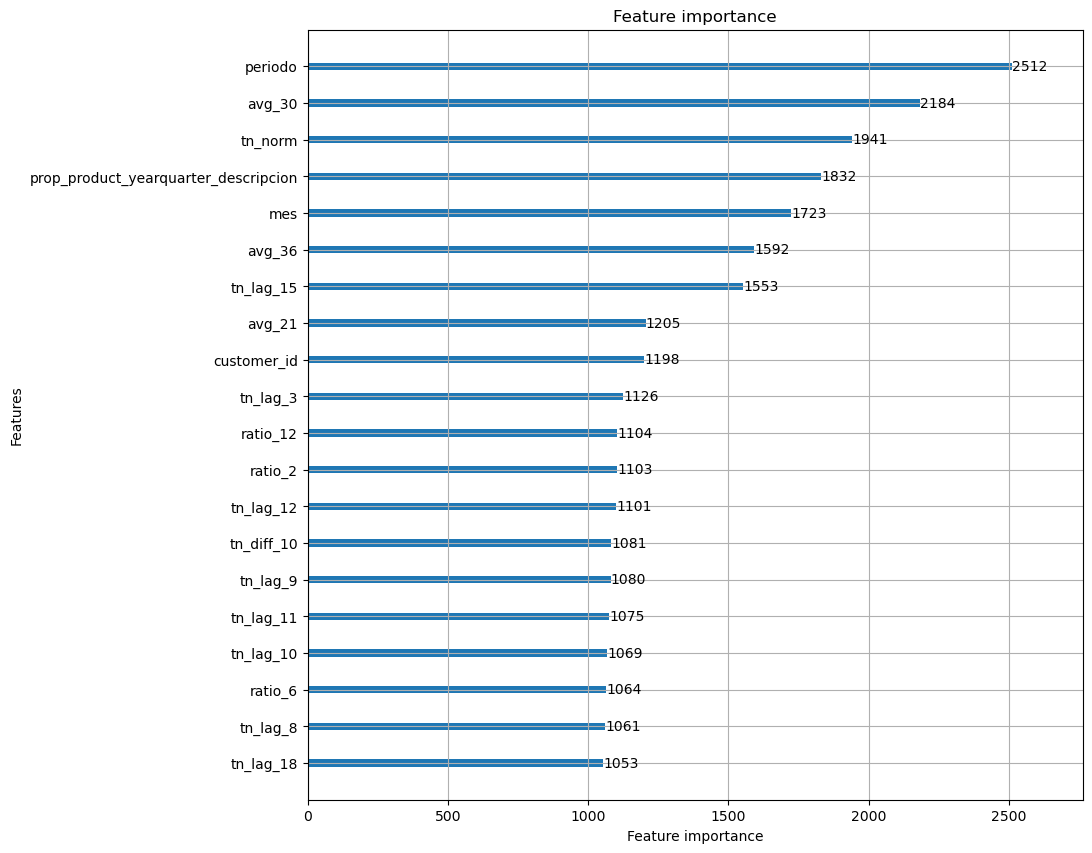

In [15]:
lgb.plot_importance(model, max_num_features=20, figsize=(10,10))
plt.show()

In [16]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.sort_values('importance_split', ascending=False, inplace=True)
feat_dibujar = importance_df[0:20]['feature_name'].reset_index(drop=True)

In [17]:
importance_df

,feature_name,importance_gain,importance_split
1,periodo,48093.609810,2512
3,avg_30,24337.778613,2184
0,tn_norm,393496.891453,1941
4,prop_product_yearquarter_descripcion,14647.060029,1832
2,mes,35414.162082,1723
...,...,...,...
183,ultimo_periodo,0.000000,0
182,cat1_median,0.000000,0
181,cat1_max,0.000000,0
180,max_2,0.000000,0


In [21]:
if dibujar_pesos==True:
    fig, axs = plt.subplots(5, 4, figsize=(20, 25))
    d = -1
    for i in range(4):
        for j in range(5):
            d+=1
            lgb.plot_split_value_histogram(model,
                            feature=feat_dibujar[d],
                            bins="auto",
                            ax=axs[j, i]
                            ,title=f"Feat: {feat_dibujar[d]}")
    plt.show()

In [22]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

--------------------------------------05_lightgbm (un intento)--------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

